In [1]:
# работа с ОС
import os
import warnings
# работа с данными
import re
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# ML
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from sklearn.metrics import mean_squared_error
# визуализация
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

D:\anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [13]:
def preprocess(data: pd.DataFrame) -> pd.DataFrame:
    data = data.drop(columns=['SDAT_S', 'ORIG', 'DEST', 'EQUIP', 'NS'])
    data['DEP_TIME'] = data['DEP_TIME'].astype(str)
    try:
        data['FLT_MINUTES'] = data['DEP_TIME'].str.slice(start=-2).astype(int) + \
                              data['DEP_TIME'].str.slice(stop=-2).astype(int) * 60
    except ValueError:
        data['FLT_MINUTES'] = None
    data['FLT_DAY_OF_WEEK'] = data['FLTDATE'].dt.dayofweek
    data['FLT_WEEKEND'] = (data['FLTDATE'].dt.dayofweek > 4).astype(int)
    data['FLT_N_DAY'] = data['FLTDATE'].dt.dayofyear
    data['FLT_YEAR'] = data['FLTDATE'].dt.year
    data['FLT_MONTH'] = data['FLTDATE'].dt.month
    data['FLT_DAY'] = data['FLTDATE'].dt.day
    data = data.drop(columns=['DEP_TIME', 'FLTDATE'])
    data = data.drop_duplicates()
    return data

def open_inventory(filename: str, start_date: str, end_date: str,
                   orig: str, dest: str) -> pd.DataFrame:
    result = []
    for date in tqdm(pd.date_range(start=start_date, end=end_date, freq='D')):
        file_name = fr'{filename}{date.strftime("%d%m%Y")}.csv'
        try:
            current_data = pd.read_csv(file_name, sep=';')
            current_data['FLTDATE'] = pd.to_datetime(current_data['FLTDATE'], format='%d.%m.%Y',
                                                     errors='coerce')
            current_data = current_data.drop_duplicates()
            current_data = current_data[(current_data['ORIG'] == orig) &
                                        (current_data['DEST'] == dest)]
            current_data = preprocess(current_data)
            result.append(current_data)
            del current_data
        except FileNotFoundError:
            continue
    if result:
        return pd.concat(result, ignore_index=True)
    return pd.DataFrame()

def get_classes(data: pd.DataFrame) -> dict:
    result = {}
    for class_code in data['BCL'].unique():
        result.setdefault(class_code, data[data['BCL'] == class_code])
    return result

Сочи-Москва за 2019 год:

In [4]:
inv = open_inventory(r"F:\new_datas\inventory\INV", '2019-01-01', '2019-12-31', 'AER', 'SVO')
inv.head(1)

100%|██████████████████████████████████████████████████████████████████████████████| 365/365 [1:35:27<00:00, 15.69s/it]


,DTD,SFLTNO,SEG_NUM,CAP,BCL,AU,PASS,FCLCLD,FLT_M,FLT_H,FLT_DAY_OF_WEEK,FLT_WEEKEND,FLT_N_DAY,FLT_YEAR,FLT_MONTH,FLT_DAY
0,217,1121,1,12,J,12,2,0,15,13,1,0,1,2019,1,1


In [5]:
inv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20271358 entries, 0 to 20271357
Data columns (total 16 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   DTD              int64 
 1   SFLTNO           int64 
 2   SEG_NUM          int64 
 3   CAP              int64 
 4   BCL              object
 5   AU               int64 
 6   PASS             int64 
 7   FCLCLD           int64 
 8   FLT_M            int32 
 9   FLT_H            int32 
 10  FLT_DAY_OF_WEEK  int64 
 11  FLT_WEEKEND      int32 
 12  FLT_N_DAY        int64 
 13  FLT_YEAR         int64 
 14  FLT_MONTH        int64 
 15  FLT_DAY          int64 
dtypes: int32(3), int64(12), object(1)
memory usage: 2.2+ GB


In [11]:
for class_code in inv['BCL'].unique():
    sub = inv[inv['BCL'] == class_code]
    sub.to_csv(fr'F:\\inv_2019_prep\\inv_{class_code}.csv', index=False)

Москва-Сочи за 2019 год:

In [14]:
inv = open_inventory(r"F:\new_datas\inventory\INV", '2019-01-01', '2019-12-31', 'SVO', 'AER')
inv.head(1)

100%|██████████████████████████████████████████████████████████████████████████████| 365/365 [2:44:27<00:00, 27.04s/it]


,DTD,SFLTNO,SEG_NUM,CAP,SCL,BCL,AU,PASS,FCLCLD,FLT_MINUTES,FLT_DAY_OF_WEEK,FLT_WEEKEND,FLT_N_DAY,FLT_YEAR,FLT_MONTH,FLT_DAY
0,217,1120,1,12,C,I,0,0,1,100,1,0,1,2019,1,1


In [15]:
inv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20271754 entries, 0 to 20271753
Data columns (total 16 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   DTD              int64 
 1   SFLTNO           int64 
 2   SEG_NUM          int64 
 3   CAP              int64 
 4   SCL              object
 5   BCL              object
 6   AU               int64 
 7   PASS             int64 
 8   FCLCLD           int64 
 9   FLT_MINUTES      object
 10  FLT_DAY_OF_WEEK  int64 
 11  FLT_WEEKEND      int32 
 12  FLT_N_DAY        int64 
 13  FLT_YEAR         int64 
 14  FLT_MONTH        int64 
 15  FLT_DAY          int64 
dtypes: int32(1), int64(12), object(3)
memory usage: 2.3+ GB


In [20]:
for cabin_code in inv['SCL'].unique():
    sub = inv[inv['SCL'] == cabin_code]
    sub.to_csv(fr'F:\inv_2019_prep_svo-aer\cabin_{cabin_code}.csv', index=False)

Подготовка данных для обучения:

In [2]:
cabin_C = pd.read_csv(r"F:\inv_2019_prep_svo-aer\cabin_C.csv")
cabin_Y = pd.read_csv(r"F:\inv_2019_prep_svo-aer\cabin_Y.csv")
print(cabin_C.info())
print(cabin_Y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5453946 entries, 0 to 5453945
Data columns (total 16 columns):
 #   Column           Dtype  
---  ------           -----  
 0   DTD              int64  
 1   SFLTNO           int64  
 2   SEG_NUM          int64  
 3   CAP              int64  
 4   SCL              object 
 5   BCL              object 
 6   AU               int64  
 7   PASS             int64  
 8   FCLCLD           int64  
 9   FLT_MINUTES      float64
 10  FLT_DAY_OF_WEEK  int64  
 11  FLT_WEEKEND      int64  
 12  FLT_N_DAY        int64  
 13  FLT_YEAR         int64  
 14  FLT_MONTH        int64  
 15  FLT_DAY          int64  
dtypes: float64(1), int64(13), object(2)
memory usage: 665.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14817808 entries, 0 to 14817807
Data columns (total 16 columns):
 #   Column           Dtype  
---  ------           -----  
 0   DTD              int64  
 1   SFLTNO           int64  
 2   SEG_NUM          int64  
 3   CAP    

In [3]:
data = cabin_C.drop(columns=['SCL'])
data = data.dropna(how='any')
data['FLT_MINUTES'] = data['FLT_MINUTES'].astype(int)
le = LabelEncoder()
data['BCL'] = le.fit_transform(data['BCL'])
X, y = data.drop(columns=['PASS']).values, data['PASS'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2098186, 14) (2098186,) (233132, 14) (233132,)


In [4]:
model = Sequential()
model.add(Dense(1024, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1024)                │          15,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 610,225 (2.33 MB)

 Trainable params: 610,225 (2.33 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
model.fit(X_train, y_train, epochs=10, batch_size=512, validation_data=(X_test, y_test), verbose=1)
y_pred = model.predict(X_test)
print(model.evaluate(X_train, y_train))
print("MSE: %.4f" % mean_squared_error(y_test, y_pred))

Epoch 1/10
4099/4099 ━━━━━━━━━━━━━━━━━━━━ 115s 28ms/step - loss: 14.3514 - val_loss: 1.0602
Epoch 2/10
4099/4099 ━━━━━━━━━━━━━━━━━━━━ 136s 26ms/step - loss: 1.0354 - val_loss: 1.0602
Epoch 3/10
4099/4099 ━━━━━━━━━━━━━━━━━━━━ 147s 27ms/step - loss: 1.0538 - val_loss: 1.0603
Epoch 4/10
4099/4099 ━━━━━━━━━━━━━━━━━━━━ 110s 27ms/step - loss: 1.0358 - val_loss: 1.0602
Epoch 5/10
4099/4099 ━━━━━━━━━━━━━━━━━━━━ 113s 28ms/step - loss: 1.0329 - val_loss: 1.0602
Epoch 6/10
4099/4099 ━━━━━━━━━━━━━━━━━━━━ 102s 25ms/step - loss: 1.0293 - val_loss: 1.0602
Epoch 7/10
4099/4099 ━━━━━━━━━━━━━━━━━━━━ 150s 27ms/step - loss: 1.0232 - val_loss: 1.0602
Epoch 8/10
4099/4099 ━━━━━━━━━━━━━━━━━━━━ 139s 26ms/step - loss: 1.0211 - val_loss: 1.0602
Epoch 9/10
4099/4099 ━━━━━━━━━━━━━━━━━━━━ 100s 24ms/step - loss: 1.0348 - val_loss: 1.0602
Epoch 10/10
4099/4099 ━━━━━━━━━━━━━━━━━━━━ 156s 28ms/step - loss: 1.0301 - val_loss: 1.0602
7286/7286 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step
65569/65569 ━━━━━━━━━━━━━━━━━━━━ 206s 3ms/st

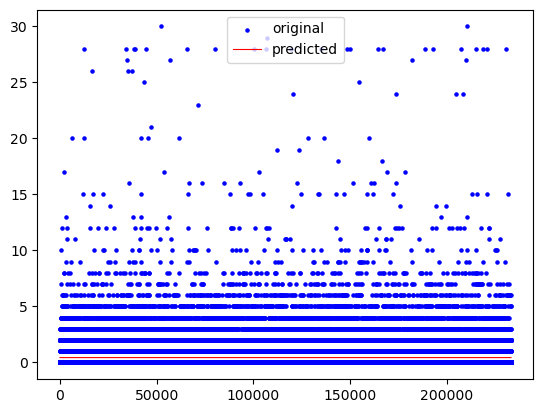

In [6]:
x_ax = range(len(y_pred))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()